# Lezione 15 — Gradient Boosting: XGBoost e LightGBM

## 📍 Posizione nel Percorso
| Lezione | Argomento |
|---------|-----------|
| 12 | Overfitting e Underfitting |
| 13 | Pipeline di Scikit-Learn |
| 14 | Alberi Decisionali e Random Forest |
| **15** | **Gradient Boosting (XGBoost, LightGBM)** ← Sei qui |
| 16 | Metriche Avanzate e Selezione Modelli |

## 🎯 Obiettivi della Lezione
1. Capire la differenza tra **Bagging** e **Boosting**
2. Comprendere il funzionamento del **Gradient Boosting**
3. Usare **XGBoost** e **LightGBM** per classificazione/regressione
4. Conoscere gli **iperparametri chiave** e come tunarli
5. Confrontare le performance con Random Forest

## 📚 Librerie utilizzate
```python
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
```

# Section 1 — Bagging vs Boosting

## Due Filosofie di Ensemble

### Bagging (Random Forest)
> "Allenare tanti modelli **in parallelo** su campioni diversi e fare la media"

```
Dataset
   │
   ├──► Sample 1 ──► Tree 1 ──┐
   ├──► Sample 2 ──► Tree 2 ──┼──► MEDIA/VOTO ──► Predizione
   ├──► Sample 3 ──► Tree 3 ──┤
   └──► Sample N ──► Tree N ──┘
   
   (alberi INDIPENDENTI, in parallelo)
```

- ✅ Riduce la **varianza** (overfitting)
- ✅ Parallelizzabile
- ❌ Non riduce il bias

### Boosting
> "Allenare tanti modelli **in sequenza**, ognuno corregge gli errori del precedente"

```
Dataset
   │
   ▼
Tree 1 ──► Errori ──► Tree 2 ──► Errori ──► Tree 3 ──► ... ──► Tree N
   │                     │                     │                   │
   └─────────────────────┴─────────────────────┴───────────────────┘
                                   │
                                   ▼
                         SOMMA PESATA ──► Predizione
                         
   (alberi SEQUENZIALI, ognuno corregge il precedente)
```

- ✅ Riduce **bias** E **varianza**
- ✅ Performance spesso superiori
- ❌ Non parallelizzabile (sequenziale)
- ❌ Più sensibile all'overfitting

## Confronto Visivo

| Aspetto | Bagging | Boosting |
|---------|---------|----------|
| **Costruzione** | Parallela | Sequenziale |
| **Focus** | Ridurre varianza | Ridurre bias + varianza |
| **Peso alberi** | Uguale | Pesato per performance |
| **Rischio overfitting** | Basso | Medio-Alto |
| **Esempio** | Random Forest | XGBoost, LightGBM |

# Section 2 — Come Funziona il Gradient Boosting

## L'Idea Matematica

1. **Inizializza** con una predizione semplice (es. media per regressione)
2. **Calcola i residui** (errori) tra predizione e valori reali
3. **Addestra un albero** per predire questi residui
4. **Aggiorna le predizioni** aggiungendo le predizioni dell'albero (con un learning rate)
5. **Ripeti** dal passo 2

### Formula

$$F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$$

Dove:
- $F_m(x)$ = predizione dopo m alberi
- $\eta$ = learning rate (0 < η ≤ 1)
- $h_m(x)$ = nuovo albero che predice i residui

## Esempio Intuitivo (Regressione)

```
Valori reali:      [10, 20, 15, 25, 18]
Predizione iniziale: 17.6 (media)
Residui:           [-7.6, 2.4, -2.6, 7.4, 0.4]

Albero 1 predice residui → correzione
Nuovi residui (più piccoli)
Albero 2 predice i nuovi residui → ulteriore correzione
...
Dopo N alberi: residui → 0
```

## Learning Rate (η)

| Learning Rate | Effetto |
|---------------|---------|
| **Alto** (0.3-1.0) | Apprendimento veloce, rischio overfitting |
| **Basso** (0.01-0.1) | Apprendimento lento, più robusto |
| **Regola** | Basso learning rate + più alberi = migliore generalizzazione |

## Gradient Boosting in Sklearn

```python
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,      # numero di alberi
    learning_rate=0.1,     # learning rate
    max_depth=3,           # profondità alberi (tipicamente bassa!)
    random_state=42
)
```

VISUALIZZAZIONE DEL PROCESSO DI GRADIENT BOOSTING


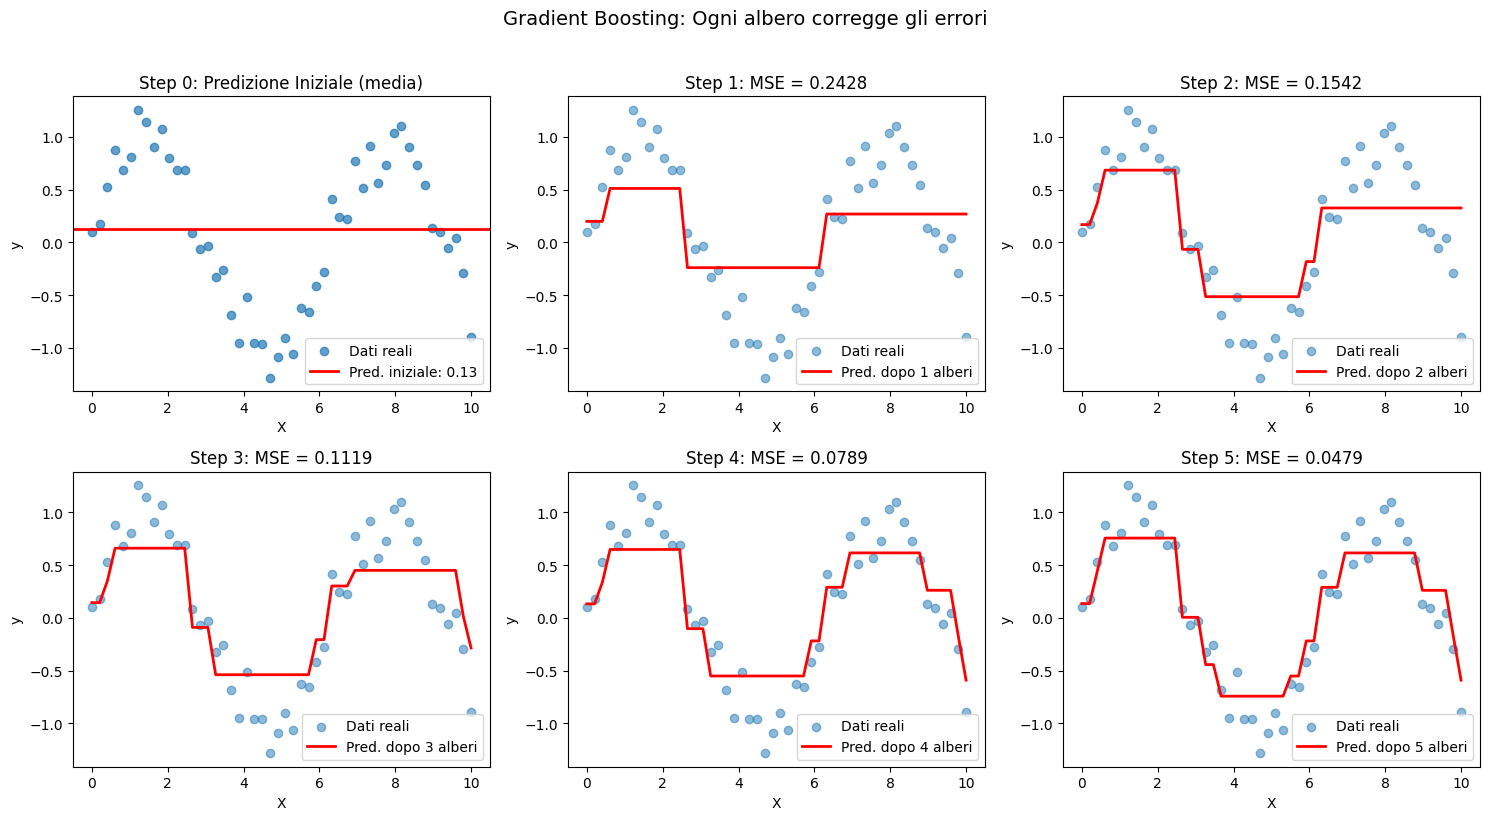


GRADIENT BOOSTING SKLEARN
LR=0.01 → Train MSE: 6.3942, Test MSE: 7.2664
LR=0.10 → Train MSE: 0.5065, Test MSE: 2.4715
LR=0.30 → Train MSE: 0.0537, Test MSE: 2.4832
LR=1.00 → Train MSE: 0.0002, Test MSE: 4.4116

📖 Osservazione:
   - Learning rate basso = errore più basso ma training più lungo
   - Learning rate troppo alto = rischio overfitting


In [5]:
# Dimostrazione: Gradient Boosting - Visualizzazione del processo

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Dataset semplice per visualizzare il processo
np.random.seed(42)
X = np.linspace(0, 10, 50).reshape(-1, 1)
y = np.sin(X.ravel()) + np.random.normal(0, 0.2, 50)

print("="*60)
print("VISUALIZZAZIONE DEL PROCESSO DI GRADIENT BOOSTING")
print("="*60)

# Simuliamo manualmente i primi step del boosting
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

# Step 0: Predizione iniziale (media)
y_pred = np.full_like(y, y.mean())
residuals = y - y_pred

axes[0].scatter(X, y, alpha=0.7, label='Dati reali')
axes[0].axhline(y=y.mean(), color='red', linewidth=2, label=f'Pred. iniziale: {y.mean():.2f}')
axes[0].set_title('Step 0: Predizione Iniziale (media)')
axes[0].legend()
axes[0].set_xlabel('X')
axes[0].set_ylabel('y')

# Step 1-5: Aggiungiamo alberi
learning_rate = 0.5
predictions = [y_pred.copy()]

for i in range(5):
    # Addestra albero sui residui
    tree = DecisionTreeRegressor(max_depth=2)
    tree.fit(X, residuals)
    
    # Predizioni dell'albero
    tree_pred = tree.predict(X)
    
    # Aggiorna predizione totale
    y_pred = y_pred + learning_rate * tree_pred
    predictions.append(y_pred.copy())
    
    # Aggiorna residui
    residuals = y - y_pred
    
    # Plot
    ax = axes[i + 1]
    ax.scatter(X, y, alpha=0.5, label='Dati reali')
    ax.plot(X, y_pred, 'r-', linewidth=2, label=f'Pred. dopo {i+1} alberi')
    ax.set_title(f'Step {i+1}: MSE = {np.mean(residuals**2):.4f}')
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('y')

plt.suptitle('Gradient Boosting: Ogni albero corregge gli errori', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Confronto con GradientBoostingRegressor di sklearn
print("\n" + "="*60)
print("GRADIENT BOOSTING SKLEARN")
print("="*60)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Dataset più realistico
np.random.seed(42)
X_full = np.random.randn(500, 10)
y_full = (3*X_full[:, 0] + 2*X_full[:, 1]**2 - X_full[:, 2]*X_full[:, 3] + 
          np.random.normal(0, 1, 500))

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.25, random_state=42
)

# Gradient Boosting con diversi learning rate
learning_rates = [0.01, 0.1, 0.3, 1.0]
results = []

for lr in learning_rates:
    gb = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=lr,
        max_depth=3,
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    train_mse = mean_squared_error(y_train, gb.predict(X_train))
    test_mse = mean_squared_error(y_test, gb.predict(X_test))
    
    results.append({
        'learning_rate': lr,
        'train_mse': train_mse,
        'test_mse': test_mse
    })
    print(f"LR={lr:4.2f} → Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")

print("\n📖 Osservazione:")
print("   - Learning rate basso = errore più basso ma training più lungo")
print("   - Learning rate troppo alto = rischio overfitting")

# Section 3 — XGBoost: eXtreme Gradient Boosting

## Perché XGBoost?

XGBoost è un'implementazione **ottimizzata** del Gradient Boosting che ha vinto molte competizioni Kaggle.

### Vantaggi rispetto al GB classico:

| Feature | Descrizione |
|---------|-------------|
| **Regularizzazione** | L1 e L2 built-in (previene overfitting) |
| **Parallelizzazione** | Costruzione alberi parallelizzata |
| **Gestione missing** | Gestisce valori mancanti nativamente |
| **Tree pruning** | Potatura più efficiente |
| **Cache optimization** | Ottimizzato per grandi dataset |

## Installazione

```bash
pip install xgboost
```

## Sintassi Base

```python
import xgboost as xgb

# Classificazione
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

# Regressione
xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
```

## Iperparametri Chiave

| Parametro | Default | Descrizione |
|-----------|---------|-------------|
| `n_estimators` | 100 | Numero di alberi (rounds) |
| `learning_rate` (eta) | 0.3 | Step size per aggiornamento |
| `max_depth` | 6 | Profondità massima alberi |
| `min_child_weight` | 1 | Min samples per foglia |
| `subsample` | 1 | Frazione righe per albero |
| `colsample_bytree` | 1 | Frazione colonne per albero |
| `reg_alpha` | 0 | Regularizzazione L1 |
| `reg_lambda` | 1 | Regularizzazione L2 |
| `gamma` | 0 | Min loss reduction per split |

## Early Stopping

XGBoost supporta **early stopping**: ferma il training quando lo score di validazione smette di migliorare.

```python
xgb_clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=False
)
```

XGBOOST: Classificazione
Dataset: (2000, 20)
Train: (1200, 20), Val: (300, 20), Test: (500, 20)

XGBOOST con Early Stopping
Test Accuracy: 0.8940
Tempo training: 0.34s
Alberi usati: 500

CONFRONTO: XGBoost vs Random Forest vs Sklearn GB
        Model  Train Acc  Test Acc  Time (s)
      XGBoost        1.0     0.902  0.072629
Random Forest        1.0     0.912  0.142141
   Sklearn GB        1.0     0.910  1.130178

FEATURE IMPORTANCE (XGBoost)


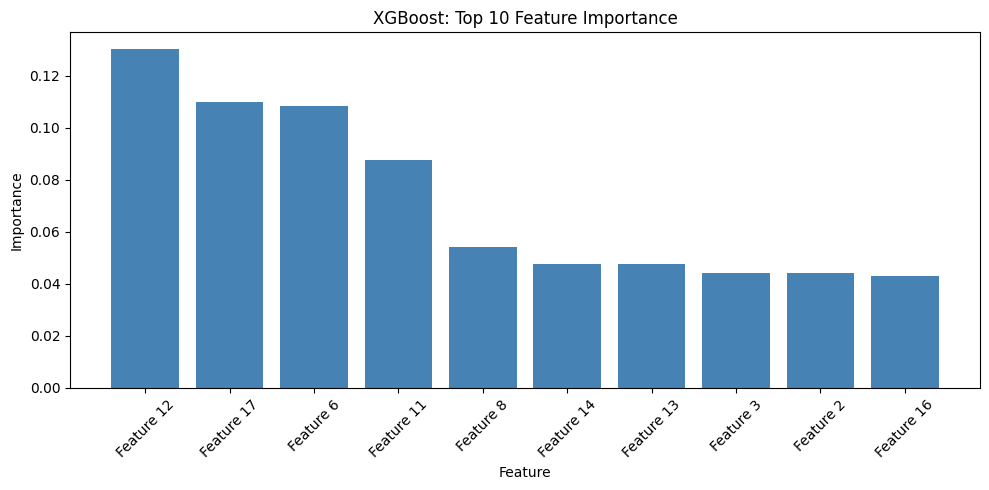


✅ XGBoost: veloce, preciso, e con early stopping integrato!


In [6]:
# Dimostrazione: XGBoost

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import time

print("="*60)
print("XGBOOST: Classificazione")
print("="*60)

# Dataset
np.random.seed(42)
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    n_redundant=4,
    n_classes=2,
    flip_y=0.1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Ulteriore split per validation (early stopping)
X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"Dataset: {X.shape}")
print(f"Train: {X_train_full.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ============================================================================
# XGBoost con Early Stopping
# ============================================================================
print(f"\n{'='*60}")
print("XGBOOST con Early Stopping")
print("="*60)

xgb_clf = xgb.XGBClassifier(
    n_estimators=500,  # numero alto, early stopping fermerà prima
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

start = time.time()
xgb_clf.fit(
    X_train_full, y_train_full,
    eval_set=[(X_val, y_val)],
    verbose=False
)
xgb_time = time.time() - start

xgb_test = xgb_clf.score(X_test, y_test)
print(f"Test Accuracy: {xgb_test:.4f}")
print(f"Tempo training: {xgb_time:.2f}s")
print(f"Alberi usati: {xgb_clf.best_iteration + 1 if hasattr(xgb_clf, 'best_iteration') else xgb_clf.n_estimators}")

# ============================================================================
# Confronto: XGBoost vs Random Forest vs Sklearn GB
# ============================================================================
print(f"\n{'='*60}")
print("CONFRONTO: XGBoost vs Random Forest vs Sklearn GB")
print("="*60)

models = {
    'XGBoost': xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Sklearn GB': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
}

results = []
for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    results.append({
        'Model': name,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Time (s)': train_time
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Visualizzazione Feature Importance XGBoost
print(f"\n{'='*60}")
print("FEATURE IMPORTANCE (XGBoost)")
print("="*60)

xgb_model = models['XGBoost']
importance = xgb_model.feature_importances_
indices = np.argsort(importance)[::-1][:10]

plt.figure(figsize=(10, 5))
plt.bar(range(10), importance[indices], color='steelblue')
plt.xticks(range(10), [f'Feature {i}' for i in indices], rotation=45)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('XGBoost: Top 10 Feature Importance')
plt.tight_layout()
plt.show()

print("\n✅ XGBoost: veloce, preciso, e con early stopping integrato!")

# Section 4 — LightGBM: Light Gradient Boosting Machine

## Perché LightGBM?

Sviluppato da Microsoft, LightGBM è ancora più **veloce** di XGBoost, specialmente su grandi dataset.

### Differenze Tecniche

| Aspetto | XGBoost | LightGBM |
|---------|---------|----------|
| **Crescita albero** | Level-wise (per livello) | Leaf-wise (per foglia) |
| **Velocità** | Veloce | Ancora più veloce |
| **Memoria** | Standard | Ottimizzata |
| **Categoriche** | Richiede encoding | Supporto nativo |

### Level-wise vs Leaf-wise

```
LEVEL-WISE (XGBoost)           LEAF-WISE (LightGBM)
Cresce un livello alla volta   Espande la foglia con max gain

      ●                              ●
     / \                            / \
    ●   ●     ← livello 1          ●   ●
   / \ / \                        / \
  ● ● ● ●     ← livello 2        ●   ●
                                    / \
                                   ●   ●  ← espansione selettiva
```

**Leaf-wise** può creare alberi più profondi e asimmetrici, ma spesso più accurati.

## Installazione

```bash
pip install lightgbm
```

## Sintassi Base

```python
import lightgbm as lgb

# Classificazione
lgb_clf = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,       # -1 = nessun limite
    num_leaves=31,      # max foglie per albero
    random_state=42
)

# Regressione
lgb_reg = lgb.LGBMRegressor(...)
```

## Iperparametri Chiave

| Parametro | Default | Descrizione |
|-----------|---------|-------------|
| `n_estimators` | 100 | Numero di alberi |
| `learning_rate` | 0.1 | Step size |
| `num_leaves` | 31 | Max foglie per albero |
| `max_depth` | -1 | Max profondità (-1 = illimitata) |
| `min_child_samples` | 20 | Min campioni per foglia |
| `subsample` | 1.0 | Frazione righe |
| `colsample_bytree` | 1.0 | Frazione colonne |
| `reg_alpha` | 0 | L1 regularization |
| `reg_lambda` | 0 | L2 regularization |

## num_leaves vs max_depth

> **Regola**: `num_leaves` < 2^`max_depth` per evitare overfitting

In [7]:
# Dimostrazione: LightGBM

import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import time
import numpy as np

print("="*60)
print("LIGHTGBM: Classificazione")
print("="*60)

# Dataset grande per mostrare velocità
np.random.seed(42)
X_large, y_large = make_classification(
    n_samples=10000,
    n_features=50,
    n_informative=25,
    n_redundant=10,
    n_classes=2,
    flip_y=0.1,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X_large, y_large, test_size=0.25, random_state=42
)

print(f"Dataset: {X_large.shape} (grande per test velocità)")

# ============================================================================
# Confronto velocità: LightGBM vs XGBoost
# ============================================================================
print(f"\n{'='*60}")
print("CONFRONTO VELOCITÀ: LightGBM vs XGBoost")
print("="*60)

# LightGBM
lgb_clf = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    num_leaves=31,
    random_state=42,
    verbose=-1
)

start = time.time()
lgb_clf.fit(X_train, y_train)
lgb_time = time.time() - start
lgb_acc = lgb_clf.score(X_test, y_test)

print(f"LightGBM: Accuracy={lgb_acc:.4f}, Tempo={lgb_time:.2f}s")

# XGBoost
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

start = time.time()
xgb_clf.fit(X_train, y_train)
xgb_time = time.time() - start
xgb_acc = xgb_clf.score(X_test, y_test)

print(f"XGBoost:  Accuracy={xgb_acc:.4f}, Tempo={xgb_time:.2f}s")
print(f"\nLightGBM è {xgb_time/lgb_time:.1f}x più veloce!")

# ============================================================================
# LightGBM con Dati Categorici (nativo)
# ============================================================================
print(f"\n{'='*60}")
print("LIGHTGBM: Supporto Nativo per Categoriche")
print("="*60)

# Dataset con categoriche
n = 2000
df_cat = pd.DataFrame({
    'feature_1': np.random.randn(n),
    'feature_2': np.random.randn(n),
    'categoria_A': np.random.choice(['low', 'medium', 'high'], n),
    'categoria_B': np.random.choice(['type1', 'type2', 'type3', 'type4'], n),
    'feature_3': np.random.randn(n),
})

# Target
df_cat['target'] = (
    df_cat['feature_1'] > 0
).astype(int) + (df_cat['categoria_A'] == 'high').astype(int)
df_cat['target'] = (df_cat['target'] > 0).astype(int)

# Converti in categorical type
df_cat['categoria_A'] = df_cat['categoria_A'].astype('category')
df_cat['categoria_B'] = df_cat['categoria_B'].astype('category')

X_cat = df_cat.drop('target', axis=1)
y_cat = df_cat['target']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_cat, y_cat, test_size=0.25, random_state=42
)

# LightGBM con categoriche native
lgb_cat = lgb.LGBMClassifier(
    n_estimators=100,
    random_state=42,
    verbose=-1
)

lgb_cat.fit(X_train_cat, y_train_cat)
cat_acc = lgb_cat.score(X_test_cat, y_test_cat)

print(f"Dataset con categoriche: {X_cat.shape}")
print(f"Tipi: {X_cat.dtypes.value_counts().to_dict()}")
print(f"Test Accuracy: {cat_acc:.4f}")
print("\n✅ LightGBM gestisce le categoriche senza OneHotEncoding!")

# Importanza features
importance = pd.DataFrame({
    'feature': X_cat.columns,
    'importance': lgb_cat.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nFeature Importance:")
print(importance.to_string(index=False))

LIGHTGBM: Classificazione
Dataset: (10000, 50) (grande per test velocità)

CONFRONTO VELOCITÀ: LightGBM vs XGBoost
LightGBM: Accuracy=0.8988, Tempo=0.30s
XGBoost:  Accuracy=0.9040, Tempo=0.44s

LightGBM è 1.5x più veloce!

LIGHTGBM: Supporto Nativo per Categoriche
Dataset con categoriche: (2000, 5)
Tipi: {dtype('float64'): 3, CategoricalDtype(categories=['high', 'low', 'medium'], ordered=False, categories_dtype=object): 1, CategoricalDtype(categories=['type1', 'type2', 'type3', 'type4'], ordered=False, categories_dtype=object): 1}
Test Accuracy: 1.0000

✅ LightGBM gestisce le categoriche senza OneHotEncoding!

Feature Importance:
    feature  importance
  feature_1         443
categoria_A         100
  feature_2          65
  feature_3          12
categoria_B           0


# Section 5 — Schema Mentale: Quale Modello Scegliere?

## Flowchart Decisionale

```
                    QUALE MODELLO?
                         │
           ┌─────────────┼─────────────┐
           ▼             ▼             ▼
      VELOCITÀ      PERFORMANCE    INTERPRETABILITÀ
      PRIORITÀ       MASSIMA         RICHIESTA
           │             │             │
           ▼             ▼             ▼
       LightGBM       XGBoost     Decision Tree
                    o LightGBM    + SHAP values
```

## Confronto Finale

| Criterio | Random Forest | XGBoost | LightGBM |
|----------|---------------|---------|----------|
| **Accuratezza** | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Velocità training** | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Memoria** | ⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐⭐ |
| **Facilità d'uso** | ⭐⭐⭐⭐⭐ | ⭐⭐⭐⭐ | ⭐⭐⭐⭐ |
| **Tuning richiesto** | Poco | Medio | Medio |
| **Overfitting** | Basso | Medio | Medio |
| **Categoriche native** | ❌ | ❌ | ✅ |

## Regole Pratiche

### 1. Baseline
```python
# Inizia sempre con Random Forest
rf = RandomForestClassifier(n_estimators=100)
```

### 2. Se serve più performance
```python
# Passa a LightGBM (più veloce) o XGBoost
lgb_clf = lgb.LGBMClassifier(n_estimators=100)
```

### 3. Tuning consigliato

```python
# Parametri da tunare (in ordine di importanza)
param_grid = {
    'n_estimators': [100, 200, 500],        # 1° più alberi
    'learning_rate': [0.01, 0.05, 0.1],     # 2° ridurre se overfitting
    'max_depth': [3, 5, 7],                 # 3° limitare profondità
    'num_leaves': [15, 31, 63],             # 4° (LightGBM)
    'reg_lambda': [0, 0.1, 1],              # 5° regularizzazione
}
```

### 4. Early Stopping (sempre!)
```python
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(10)]  # LightGBM
)
```

## Errori Comuni

| ❌ Errore | ✅ Soluzione |
|-----------|-------------|
| Troppi alberi senza early stopping | Usa sempre validation set |
| Learning rate alto | Inizia con 0.05-0.1 |
| max_depth troppo alto | Per boosting, 3-7 è sufficiente |
| Non scalare i dati | Per GB non serve scaling! |
| Dimenticare random_state | Sempre fissare per riproducibilità |

# Section 6 — Esercizi Svolti

---

## 🎯 Esercizio 15.1 — Confronto Completo: RF vs XGBoost vs LightGBM

**Obiettivo**: Confrontare le performance dei tre modelli su un dataset.

**Consegna**:
1. Genera un dataset di classificazione (1000 campioni, 20 features)
2. Addestra: Random Forest, XGBoost, LightGBM (tutti con 100 alberi)
3. Calcola accuracy e tempo di training per ciascuno
4. Visualizza i risultati con un grafico a barre
5. Dichiara il vincitore

ESERCIZIO 15.1 — Confronto RF vs XGBoost vs LightGBM

📊 Dataset generato:
   - Campioni totali: 1000
   - Features: 20
   - Training set: 800
   - Test set: 200

🏋️ Training e valutazione:
--------------------------------------------------
   Random Forest   → Accuracy: 0.9450 | Tempo: 0.1283s
   XGBoost         → Accuracy: 0.9400 | Tempo: 0.0549s
   LightGBM        → Accuracy: 0.9550 | Tempo: 0.0438s


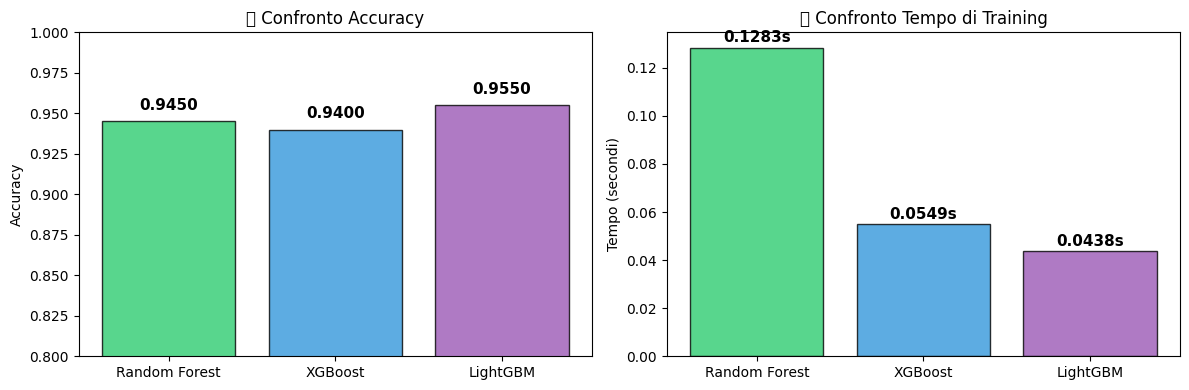


🏆 RISULTATO FINALE

📋 Tabella riassuntiva:
      Modello  Accuracy  Tempo (s)  Score Combinato
Random Forest     0.945   0.128347         6.830631
      XGBoost     0.940   0.054881        14.488095
     LightGBM     0.955   0.043802        17.750105

✅ Modello più accurato: LightGBM
⚡ Modello più veloce: LightGBM

💡 Conclusione: Su questo dataset, i modelli boosting competono
   con Random Forest. La scelta dipende dal trade-off accuracy/velocità.


In [8]:
# ============================================
# ESERCIZIO 15.1 — SOLUZIONE COMPLETA
# Confronto Completo: RF vs XGBoost vs LightGBM
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 1. Generazione dataset
print("=" * 60)
print("ESERCIZIO 15.1 — Confronto RF vs XGBoost vs LightGBM")
print("=" * 60)

X, y = make_classification(
    n_samples=1000, 
    n_features=20, 
    n_informative=15,
    n_redundant=3,
    n_classes=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📊 Dataset generato:")
print(f"   - Campioni totali: {len(X)}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Training set: {len(X_train)}")
print(f"   - Test set: {len(X_test)}")

# 2. Definizione modelli (tutti con 100 alberi)
modelli = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, verbosity=0, n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbosity=-1, n_jobs=-1)
}

# 3. Training e valutazione
risultati = {'Modello': [], 'Accuracy': [], 'Tempo (s)': []}

print("\n🏋️ Training e valutazione:")
print("-" * 50)

for nome, modello in modelli.items():
    # Timing
    start_time = time.time()
    modello.fit(X_train, y_train)
    tempo_training = time.time() - start_time
    
    # Predizione
    y_pred = modello.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Salva risultati
    risultati['Modello'].append(nome)
    risultati['Accuracy'].append(accuracy)
    risultati['Tempo (s)'].append(tempo_training)
    
    print(f"   {nome:15} → Accuracy: {accuracy:.4f} | Tempo: {tempo_training:.4f}s")

# 4. Visualizzazione risultati
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colori = ['#2ecc71', '#3498db', '#9b59b6']  # Verde, Blu, Viola

# Accuracy
ax1 = axes[0]
bars1 = ax1.bar(risultati['Modello'], risultati['Accuracy'], color=colori, edgecolor='black', alpha=0.8)
ax1.set_ylabel('Accuracy')
ax1.set_title('📊 Confronto Accuracy')
ax1.set_ylim(0.8, 1.0)
for bar, acc in zip(bars1, risultati['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Tempo
ax2 = axes[1]
bars2 = ax2.bar(risultati['Modello'], risultati['Tempo (s)'], color=colori, edgecolor='black', alpha=0.8)
ax2.set_ylabel('Tempo (secondi)')
ax2.set_title('⏱️ Confronto Tempo di Training')
for bar, tempo in zip(bars2, risultati['Tempo (s)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{tempo:.4f}s', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# 5. Dichiarazione vincitore
print("\n" + "=" * 60)
print("🏆 RISULTATO FINALE")
print("=" * 60)

df_risultati = pd.DataFrame(risultati)
df_risultati['Score Combinato'] = df_risultati['Accuracy'] / (df_risultati['Tempo (s)'] + 0.01)

print("\n📋 Tabella riassuntiva:")
print(df_risultati.to_string(index=False))

vincitore = df_risultati.loc[df_risultati['Accuracy'].idxmax(), 'Modello']
piu_veloce = df_risultati.loc[df_risultati['Tempo (s)'].idxmin(), 'Modello']

print(f"\n✅ Modello più accurato: {vincitore}")
print(f"⚡ Modello più veloce: {piu_veloce}")
print(f"\n💡 Conclusione: Su questo dataset, i modelli boosting competono")
print(f"   con Random Forest. La scelta dipende dal trade-off accuracy/velocità.")

---

## 🎯 Esercizio 15.2 — LightGBM per Regressione con Early Stopping

**Obiettivo**: Usare LightGBM per un problema di regressione con early stopping.

**Consegna**:
1. Genera un dataset di regressione (California Housing o sintetico)
2. Configura LightGBM con validation set e early stopping
3. Monitora l'andamento della loss durante il training
4. Visualizza la curva di learning
5. Analizza quando il modello smette di migliorare

In [ ]:
# ============================================
# ESERCIZIO 15.2 — SOLUZIONE COMPLETA
# LightGBM per Regressione con Early Stopping
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ESERCIZIO 15.2 — LightGBM Regressione con Early Stopping")
print("=" * 60)

try:
    california = fetch_california_housing()
    X = california.data
    y = california.target
    feature_names = california.feature_names
    print("✅ Dataset caricato via sklearn")
except Exception as e:
    print(f"⚠️ Download fallito ({e}) → uso CSV locale")
    df = pd.read_csv("california_housing.csv")
    X = df.drop(columns=["MedHouseVal"]).values
    y = df["MedHouseVal"].values
    feature_names = df.drop(columns=["MedHouseVal"]).columns.tolist()

print(f"\n📊 Dataset: California Housing")
print(f"   - Campioni: {len(X)}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Target: Prezzo mediano case")



# 2. Split: Train / Validation / Test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print(f"\n📂 Split dei dati:")
print(f"   - Training: {len(X_train)}")
print(f"   - Validation: {len(X_val)}")
print(f"   - Test: {len(X_test)}")

# 3. Configurazione LightGBM con callback per tracciare la loss
evals_result = {}

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,           # Massimo numero alberi
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    random_state=42,
    verbosity=-1,
    n_jobs=-1
)

print("\n🏋️ Training con Early Stopping...")
print("-" * 50)

# Training con early stopping
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='rmse',
    callbacks=[
        lgb.early_stopping(stopping_rounds=30, verbose=False),
        lgb.record_evaluation(evals_result)
    ]
)

# 4. Analisi risultati
n_alberi_usati = lgb_model.n_estimators_
print(f"\n📈 Risultati del training:")
print(f"   - Alberi massimi configurati: 500")
print(f"   - Alberi effettivamente usati: {n_alberi_usati}")
print(f"   - Alberi risparmiati: {500 - n_alberi_usati} ({(500-n_alberi_usati)/500*100:.1f}%)")

# Predizioni finali
y_pred = lgb_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print(f"\n🎯 Performance su Test Set:")
print(f"   - RMSE: {rmse_test:.4f}")
print(f"   - R² Score: {r2_test:.4f}")

# 5. Visualizzazione curva di learning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Curva RMSE
ax1 = axes[0]
train_rmse = evals_result['training']['rmse']
val_rmse = evals_result['valid_1']['rmse']

ax1.plot(train_rmse, label='Training RMSE', color='#3498db', linewidth=2)
ax1.plot(val_rmse, label='Validation RMSE', color='#e74c3c', linewidth=2)
ax1.axvline(x=n_alberi_usati-1, color='green', linestyle='--', linewidth=2, 
            label=f'Early Stop (iter {n_alberi_usati})')
ax1.set_xlabel('Iterazione (numero alberi)')
ax1.set_ylabel('RMSE')
ax1.set_title('📉 Curva di Learning - RMSE')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Zoom sulla zona di early stopping
ax2 = axes[1]
start_zoom = max(0, n_alberi_usati - 80)
end_zoom = min(len(val_rmse), n_alberi_usati + 20)

ax2.plot(range(start_zoom, end_zoom), train_rmse[start_zoom:end_zoom], 
         label='Training RMSE', color='#3498db', linewidth=2, marker='o', markersize=3)
ax2.plot(range(start_zoom, end_zoom), val_rmse[start_zoom:end_zoom], 
         label='Validation RMSE', color='#e74c3c', linewidth=2, marker='o', markersize=3)
ax2.axvline(x=n_alberi_usati-1, color='green', linestyle='--', linewidth=2, 
            label=f'Early Stop')
ax2.set_xlabel('Iterazione')
ax2.set_ylabel('RMSE')
ax2.set_title('🔍 Zoom: Punto di Early Stopping')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Analisi del comportamento
print("\n" + "=" * 60)
print("📊 ANALISI DEL COMPORTAMENTO")
print("=" * 60)

min_val_idx = np.argmin(val_rmse)
min_val_rmse = val_rmse[min_val_idx]
train_rmse_at_min = train_rmse[min_val_idx]

print(f"\n🎯 Punto ottimale trovato:")
print(f"   - Iterazione con minimo validation RMSE: {min_val_idx + 1}")
print(f"   - Validation RMSE minimo: {min_val_rmse:.4f}")
print(f"   - Training RMSE a quel punto: {train_rmse_at_min:.4f}")
print(f"   - Gap Train-Val: {min_val_rmse - train_rmse_at_min:.4f}")

print(f"\n💡 Interpretazione:")
print(f"   - Il training RMSE continua a scendere (il modello memorizza)")
print(f"   - Il validation RMSE si stabilizza/peggiora → OVERFITTING!")
print(f"   - Early stopping ferma il training al momento giusto")
print(f"   - Risparmio computazionale: -{500 - n_alberi_usati} iterazioni")

---

## 🎯 Esercizio 15.3 — Tuning Iperparametri XGBoost con GridSearchCV

**Obiettivo**: Trovare la combinazione ottimale di iperparametri per XGBoost.

**Consegna**:
1. Definisci una griglia di iperparametri (learning_rate, max_depth, n_estimators)
2. Esegui GridSearchCV con cross-validation
3. Identifica i migliori parametri
4. Confronta performance prima/dopo tuning
5. Visualizza l'impatto dei diversi parametri

ESERCIZIO 15.3 — Tuning XGBoost con GridSearchCV

📊 Dataset: Breast Cancer Wisconsin
   - Campioni: 569
   - Features: 30
   - Classi: Maligno (0), Benigno (1)

📌 STEP 1: Modello Base (default parameters)

🔹 Parametri default:
   - n_estimators: None
   - max_depth: None
   - learning_rate: None

📈 Performance base:
   - Test Accuracy: 0.9561
   - CV Mean Accuracy: 0.9648 (±0.0146)

📌 STEP 2: GridSearchCV

🔍 Griglia di ricerca:
   - n_estimators: [50, 100, 200]
   - max_depth: [3, 5, 7]
   - learning_rate: [0.01, 0.1, 0.2]
   - subsample: [0.8, 1.0]

   📊 Totale combinazioni: 54
   📊 Con 5-fold CV: 270 fit

⏳ Esecuzione GridSearchCV (potrebbe richiedere qualche secondo)...

✅ GridSearchCV completato!

📌 STEP 3: Migliori Parametri Trovati

🏆 Best Parameters:
   - learning_rate: 0.2
   - max_depth: 3
   - n_estimators: 100
   - subsample: 0.8

📈 Best CV Score: 0.9714

📌 STEP 4: Confronto Prima vs Dopo Tuning

📊 Confronto su Test Set:
   ┌─────────────────┬────────────────┐
   │     Model

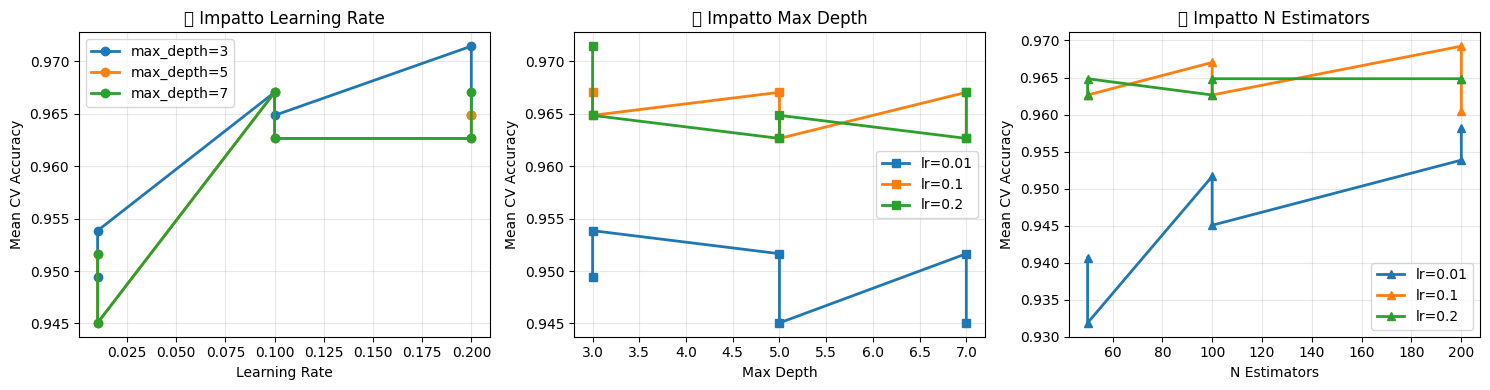


🏆 TOP 5 COMBINAZIONI


 param_n_estimators  param_max_depth  param_learning_rate  param_subsample  mean_test_score  std_test_score  rank_test_score
                100                3                  0.2              0.8         0.971429        0.019160                1
                200                3                  0.2              0.8         0.971429        0.020382                1
                200                5                  0.1              0.8         0.969231        0.010767                3
                200                7                  0.1              0.8         0.969231        0.010767                3
                100                3                  0.1              0.8         0.967033        0.018388                5

💡 CONCLUSIONI

📌 Osservazioni sul tuning:
   1. Learning rate basso richiede più alberi (trade-off)
   2. max_depth troppo alto può causare overfitting
   3. GridSearchCV è esaustivo ma costoso → RandomizedSearchCV per grigli

In [15]:
# ============================================
# ESERCIZIO 15.3 — SOLUZIONE COMPLETA
# Tuning Iperparametri XGBoost con GridSearchCV
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

print("=" * 60)
print("ESERCIZIO 15.3 — Tuning XGBoost con GridSearchCV")
print("=" * 60)

# 1. Caricamento dataset
data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n📊 Dataset: Breast Cancer Wisconsin")
print(f"   - Campioni: {len(X)}")
print(f"   - Features: {X.shape[1]}")
print(f"   - Classi: Maligno (0), Benigno (1)")

# 2. Modello base (senza tuning)
print("\n" + "=" * 60)
print("📌 STEP 1: Modello Base (default parameters)")
print("=" * 60)

xgb_base = xgb.XGBClassifier(random_state=42, verbosity=0, n_jobs=-1)
xgb_base.fit(X_train, y_train)

y_pred_base = xgb_base.predict(X_test)
acc_base = accuracy_score(y_test, y_pred_base)

cv_scores_base = cross_val_score(xgb_base, X_train, y_train, cv=5)

print(f"\n🔹 Parametri default:")
print(f"   - n_estimators: {xgb_base.n_estimators}")
print(f"   - max_depth: {xgb_base.max_depth}")
print(f"   - learning_rate: {xgb_base.learning_rate}")

print(f"\n📈 Performance base:")
print(f"   - Test Accuracy: {acc_base:.4f}")
print(f"   - CV Mean Accuracy: {cv_scores_base.mean():.4f} (±{cv_scores_base.std():.4f})")

# 3. Definizione griglia iperparametri
print("\n" + "=" * 60)
print("📌 STEP 2: GridSearchCV")
print("=" * 60)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

n_combinazioni = np.prod([len(v) for v in param_grid.values()])
print(f"\n🔍 Griglia di ricerca:")
for param, values in param_grid.items():
    print(f"   - {param}: {values}")
print(f"\n   📊 Totale combinazioni: {n_combinazioni}")
print(f"   📊 Con 5-fold CV: {n_combinazioni * 5} fit")

# 4. Esecuzione GridSearchCV
print("\n⏳ Esecuzione GridSearchCV (potrebbe richiedere qualche secondo)...")

xgb_grid = xgb.XGBClassifier(random_state=42, verbosity=0, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_grid,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=True,
    verbose=0
)

grid_search.fit(X_train, y_train)

print("\n✅ GridSearchCV completato!")

# 5. Risultati migliori
print("\n" + "=" * 60)
print("📌 STEP 3: Migliori Parametri Trovati")
print("=" * 60)

print(f"\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📈 Best CV Score: {grid_search.best_score_:.4f}")

# 6. Confronto prima/dopo tuning
print("\n" + "=" * 60)
print("📌 STEP 4: Confronto Prima vs Dopo Tuning")
print("=" * 60)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"\n📊 Confronto su Test Set:")
print(f"   ┌─────────────────┬────────────────┐")
print(f"   │     Modello     │   Accuracy     │")
print(f"   ├─────────────────┼────────────────┤")
print(f"   │ Base (default)  │    {acc_base:.4f}       │")
print(f"   │ Tuned (best)    │    {acc_tuned:.4f}       │")
print(f"   └─────────────────┴────────────────┘")

miglioramento = (acc_tuned - acc_base) * 100
print(f"\n   {'✅' if miglioramento > 0 else '⚠️'} Miglioramento: {miglioramento:+.2f}%")

# 7. Visualizzazione impatto parametri
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

results_df = pd.DataFrame(grid_search.cv_results_)

# Impatto learning_rate
ax1 = axes[0]
for depth in param_grid['max_depth']:
    mask = (results_df['param_max_depth'] == depth) & (results_df['param_n_estimators'] == 100)
    subset = results_df[mask]
    ax1.plot(subset['param_learning_rate'], subset['mean_test_score'], 
             marker='o', label=f'max_depth={depth}', linewidth=2)
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Mean CV Accuracy')
ax1.set_title('📊 Impatto Learning Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Impatto max_depth
ax2 = axes[1]
for lr in param_grid['learning_rate']:
    mask = (results_df['param_learning_rate'] == lr) & (results_df['param_n_estimators'] == 100)
    subset = results_df[mask]
    ax2.plot(subset['param_max_depth'], subset['mean_test_score'], 
             marker='s', label=f'lr={lr}', linewidth=2)
ax2.set_xlabel('Max Depth')
ax2.set_ylabel('Mean CV Accuracy')
ax2.set_title('📊 Impatto Max Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Impatto n_estimators
ax3 = axes[2]
for lr in param_grid['learning_rate']:
    mask = (results_df['param_learning_rate'] == lr) & (results_df['param_max_depth'] == 5)
    subset = results_df[mask]
    ax3.plot(subset['param_n_estimators'], subset['mean_test_score'], 
             marker='^', label=f'lr={lr}', linewidth=2)
ax3.set_xlabel('N Estimators')
ax3.set_ylabel('Mean CV Accuracy')
ax3.set_title('📊 Impatto N Estimators')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8. Top 5 combinazioni
print("\n" + "=" * 60)
print("🏆 TOP 5 COMBINAZIONI")
print("=" * 60)

top5 = results_df.nsmallest(5, 'rank_test_score')[
    ['param_n_estimators', 'param_max_depth', 'param_learning_rate', 
     'param_subsample', 'mean_test_score', 'std_test_score', 'rank_test_score']
].reset_index(drop=True)

print("\n")
print(top5.to_string(index=False))

print("\n" + "=" * 60)
print("💡 CONCLUSIONI")
print("=" * 60)
print("""
📌 Osservazioni sul tuning:
   1. Learning rate basso richiede più alberi (trade-off)
   2. max_depth troppo alto può causare overfitting
   3. GridSearchCV è esaustivo ma costoso → RandomizedSearchCV per griglie grandi
   4. Sempre validare su test set separato dopo tuning
   
⚠️ ATTENZIONE: Se il miglioramento è minimo, il modello base era già buono!
   Il tuning non sempre porta grandi benefici su dataset "facili".
""")

---

# 📚 Conclusione — Lezione 15

## 🎯 Cosa abbiamo imparato

In questa lezione abbiamo esplorato il **Gradient Boosting**, una delle tecniche più potenti nel machine learning:

### Concetti Chiave:

| Concetto | Descrizione |
|----------|-------------|
| **Bagging vs Boosting** | Bagging = parallelo, riduce varianza; Boosting = sequenziale, riduce bias |
| **Gradient Boosting** | Ogni albero corregge gli errori (residui) del precedente |
| **Learning Rate** | Controlla il contributo di ogni albero (piccolo = robusto ma lento) |
| **XGBoost** | Implementazione ottimizzata con L1/L2 regolarizzazione |
| **LightGBM** | Leaf-wise growth, più veloce, gestione nativa categoriche |
| **Early Stopping** | Ferma il training quando la validation peggiora |

---

## 📝 BIGNAMI — Gradient Boosting

```
┌─────────────────────────────────────────────────────────────────┐
│                    GRADIENT BOOSTING                             │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  IDEA: F(x) = f₁(x) + η·f₂(x) + η·f₃(x) + ...                  │
│        Ogni albero fₙ predice i RESIDUI di Fₙ₋₁                 │
│                                                                  │
├─────────────────────────────────────────────────────────────────┤
│  XGBOOST                    │  LIGHTGBM                         │
│  ─────────────────────────  │  ─────────────────────────        │
│  • Level-wise growth        │  • Leaf-wise growth (più veloce)  │
│  • L1 + L2 regolarizzazione │  • Nativo per categoriche         │
│  • Syntax: XGBClassifier()  │  • Syntax: LGBMClassifier()       │
│  • Robusto, ben testato     │  • Ideale per big data            │
│                                                                  │
├─────────────────────────────────────────────────────────────────┤
│  IPERPARAMETRI CHIAVE:                                          │
│  ─────────────────────                                          │
│  • n_estimators: numero alberi (più = meglio, ma più lento)     │
│  • learning_rate: peso di ogni albero (0.01-0.3 tipico)         │
│  • max_depth: profondità (3-10, più = rischio overfitting)      │
│  • subsample: % campioni per albero (0.8-1.0)                   │
│  • colsample_bytree: % features per albero                      │
│                                                                  │
├─────────────────────────────────────────────────────────────────┤
│  EARLY STOPPING:                                                │
│  ─────────────                                                  │
│  xgb.fit(X, y, eval_set=[(X_val, y_val)],                      │
│          early_stopping_rounds=30)                              │
│                                                                  │
│  lgb.fit(X, y, eval_set=[(X_val, y_val)],                      │
│          callbacks=[lgb.early_stopping(30)])                    │
│                                                                  │
├─────────────────────────────────────────────────────────────────┤
│  QUANDO USARE COSA:                                             │
│  ──────────────────                                             │
│  • Random Forest → baseline, dati rumorosi, interpretabilità   │
│  • XGBoost → competizioni, performance massima                  │
│  • LightGBM → big data, categoriche, velocità                  │
│                                                                  │
└─────────────────────────────────────────────────────────────────┘
```

---

## 🔗 Prossima Lezione

**Lezione 16**: Metriche Avanzate di Valutazione
- Precision, Recall, F1-Score
- Matrice di confusione
- Curve ROC e AUC
- Curva Precision-Recall
- Scelta della soglia di classificazione